In [1]:
%%time
import matplotlib
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin
from marss2l import loaders
import logging
import os

import uuid
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score, accuracy_score,\
    average_precision_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from marss2l.plot import C0, C1, C2, C3
import seaborn as sns
import json

logger = logging.getLogger(__name__)
setup_stream_logger(logger)


fs = get_remote_filesystem()
os.makedirs("figures", exist_ok=True)

Using account key
CPU times: user 8.93 s, sys: 2.19 s, total: 11.1 s
Wall time: 7.07 s


In [2]:
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv"  # loaders.CSV_PATH_DEFAULT
dataframe_data_traintest = loaders.read_csv(csv_path,
                                            add_columns_for_analysis=True, fs=fs, 
                                            split="all", 
                                            add_case_study=True, add_loc_type=True)
dataframe_data_traintest.shape

(93581, 59)

In [3]:
from marss2l.validation_utils import load_stats_and_config
pd.options.display.float_format = "{:,.2f}".format


basefolder_experiments = "az://public/MARS-S2L/train_logs_revision/"


outs = []
ids_all = None


expload = [
          ("MARSS2L_20250326", "MARS-S2L (th25)", "preds_test_2023thr25"),
          ("MARSS2L_20250326", "MARS-S2L (th50)", "preds_test_2023thr50"),
          ("MARSS2L_20250326", "MARS-S2L (th75)", "preds_test_2023thr75"),
          ("MARSS2L_20250326", "MARS-S2L", "preds_test_2023th100"),
          ("MARSS2L_20250326", "MARS-S2L  (th125)", "preds_test_2023thr125"),
          ("MARSS2L_20250326", "MARS-S2L  (th150)", "preds_test_2023thr150"),
          ("MARSS2L_20250326", "MARS-S2L  (th175)", "preds_test_2023thr175")
]

config_experiments = dict()
for  train_folder, model_name, csv_file in  expload:
    output, config = load_stats_and_config(train_folder, model_name, csv_file=csv_file,
                                           basefolder_experiments=basefolder_experiments,fs=fs,
                                           logger=logger)
    if config is not None:
        config_experiments[model_name] = config
    
    ids_iter = set(output["id_loc_image"].values)
    if ids_all is None:
        ids_all = ids_iter
    else:
        ids_all = ids_all.intersection(ids_iter)
    outs.append(output)
print(f"There are {len(ids_all)} common ids")

outs = pd.concat(outs, ignore_index=True)
outs = outs[outs.id_loc_image.isin(ids_all)].copy()

outs.groupby(["model_name","target"])[["id_loc_image"]].count()

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-13 16:44:04,078 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/preds_test_2023thr25.csv
2025-06-13 16:44:10,730 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/config_experiment.json
2025-06-13 16:44:11,289 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/preds_test_2023thr50.csv
2025-06-13 16:44:17,098 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/config_experiment.json
2025-06-13 16:44:17,695 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326

There are 43529 common ids


id_loc_image
model_name        target              
MARS-S2L          0              41716
                  1               1813
MARS-S2L  (th125) 0              41716
                  1               1813
MARS-S2L  (th150) 0              41716
                  1               1813
MARS-S2L  (th175) 0              41716
                  1               1813
MARS-S2L (th25)   0              41716
                  1               1813
MARS-S2L (th50)   0              41716
                  1               1813
MARS-S2L (th75)   0              41716
                  1               1813

In [4]:
threshold_mbmp = -.99
threshold_marss2l = 0.5
outs_merge = outs.drop(["location_name", "tile"], axis=1)
outs_same_period_with_fluxrate = pd.merge(outs_merge, dataframe_data_traintest[dataframe_data_traintest.split_name == "test_2023"], 
                                          on ="id_loc_image")
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate.drop("target", axis=1) # Use isplume as GT from dataframe_data_traintest
outs_same_period_with_fluxrate["isplumenum"] = outs_same_period_with_fluxrate["isplume"].astype(int)
# outs_same_period_with_fluxrate["isplumeprednum"] = (outs_same_period_with_fluxrate["scene_pred"] > 0.5).astype(int)
outs_same_period_with_fluxrate["isplumeprednum"] = outs_same_period_with_fluxrate.apply(lambda row: row.scene_pred > threshold_mbmp if row.model_name.startswith("MBMP") else row.scene_pred > threshold_marss2l, axis=1).astype(int)
outs_same_period_with_fluxrate["scenepredcontinuous"] = outs_same_period_with_fluxrate["scene_pred"]
outs_same_period_with_fluxrate.id_loc_image.nunique()

43529

### Drop offshore locations

In [5]:
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate[~outs_same_period_with_fluxrate.offshore].copy()
outs_same_period_with_fluxrate.id_loc_image.nunique()

41447

In [6]:
from marss2l.metrics import get_scenelevel_metrics, get_pixellevel_metrics
    
mets = []
for model, dg in outs_same_period_with_fluxrate.groupby("model_name"):
    threshold = threshold_marss2l if not model.startswith("MBMP") else threshold_mbmp
    mets_iter = get_scenelevel_metrics(dg.scenepredcontinuous, dg.isplumenum, threshold=threshold,
                                       as_percentage=True)
    mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN,
                                     as_percentage=True)
    mets_iter.update(mets_seg)
    mets_iter.update({"nsamples": dg.shape[0],
                 "nlocs": dg.location_name.nunique(),
                 "nplumes": dg.isplumenum.sum(),
                 "nnoplume": (1-dg.isplumenum).sum(),
                 "model_name": model})
    mets.append(mets_iter)

mets = pd.DataFrame(mets).sort_values(["balanced_accuracy"], ascending=False)
overall_mets = mets[["model_name"]+[c for c in mets.columns if c != "model_name"]].copy()
overall_mets

,model_name,average_precision,precision,recall,accuracy,binary_cross_entropy,fpr,balanced_accuracy,segmentation_precision,segmentation_recall,segmentation_accuracy,segmentation_f1,segmentation_fpr,iou,nsamples,nlocs,nplumes,nnoplume
5,MARS-S2L (th50),64.58,30.56,80.50,91.34,0.26,8.18,86.16,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
4,MARS-S2L (th25),64.28,28.76,81.00,90.60,0.29,8.97,86.02,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
6,MARS-S2L (th75),64.84,31.84,79.54,91.84,0.25,7.61,85.96,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
0,MARS-S2L,64.79,33.10,78.97,92.27,0.23,7.14,85.92,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
1,MARS-S2L (th125),64.79,34.29,78.18,92.65,0.22,6.70,85.74,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
2,MARS-S2L (th150),64.73,35.36,77.85,92.96,0.21,6.36,85.74,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673
3,MARS-S2L (th175),64.72,36.34,77.17,93.24,0.20,6.04,85.56,40.64,62.62,99.79,49.29,0.15,32.70,41447,1236,1774,39673


In [7]:
print(overall_mets[['model_name', 'average_precision', 'precision', 'recall', "fpr"]].to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
model_name & average_precision & precision & recall & fpr \\
\midrule
MARS-S2L (th50) & 64.58 & 30.56 & 80.50 & 8.18 \\
MARS-S2L (th25) & 64.28 & 28.76 & 81.00 & 8.97 \\
MARS-S2L (th75) & 64.84 & 31.84 & 79.54 & 7.61 \\
MARS-S2L & 64.79 & 33.10 & 78.97 & 7.14 \\
MARS-S2L  (th125) & 64.79 & 34.29 & 78.18 & 6.70 \\
MARS-S2L  (th150) & 64.73 & 35.36 & 77.85 & 6.36 \\
MARS-S2L  (th175) & 64.72 & 36.34 & 77.17 & 6.04 \\
\bottomrule
\end{tabular}



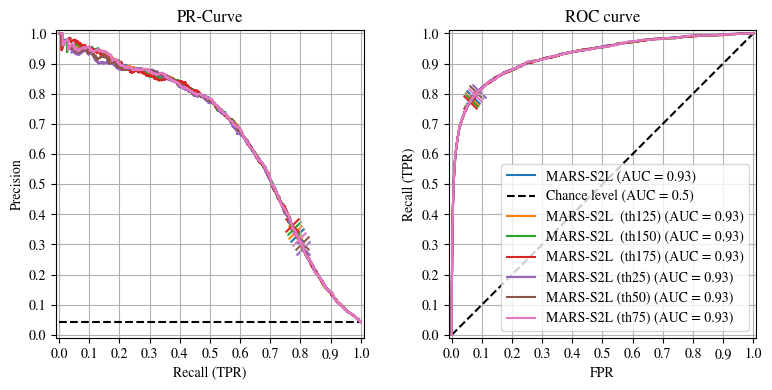

In [8]:
fig, ax = plt.subplots(1,2,figsize=(8, 4),tight_layout=True, sharey=False)
iaxes_roc = 1
iaxes_pr = 0
overall_mets_indexed = overall_mets.set_index("model_name")
# models_plot_prcurve = ["MBMP", "CH4Net", "MARS-S2L", "MARS-S2L (no sim)", "CH4Net (sim)"] # "MARS-S2L (no sim)", "CH4Net (sim)"
df_show = outs_same_period_with_fluxrate.copy()
for _i_prev, (model_name, out_same_period) in enumerate(df_show.groupby("model_name")):
    dg = out_same_period
    display = PrecisionRecallDisplay.from_predictions(dg.isplumenum, dg.scenepredcontinuous,
                                                      plot_chance_level=_i_prev == 0,
                                                      ax=ax[iaxes_pr], name=model_name)
    
    display = RocCurveDisplay.from_predictions(dg.isplumenum, dg.scenepredcontinuous,
                                               plot_chance_level=_i_prev == 0,
                                                ax=ax[iaxes_roc], name=model_name)
    ax[0].scatter([overall_mets_indexed.loc[model_name, "recall"]/100], 
                  [overall_mets_indexed.loc[model_name, "precision"]/100],
                  s=100,
                  marker="x")
    ax[1].scatter([overall_mets_indexed.loc[model_name, "fpr"]/100],
                  [overall_mets_indexed.loc[model_name, "recall"]/100], 
                  s=100,
                  marker="x")
    
# ax[iaxes_pr].legend(loc="upper right")
ax[iaxes_pr].get_legend().remove()
ax[iaxes_roc].grid()
ax[iaxes_pr].grid()
ax[iaxes_pr].set_xticks(np.arange(0,1.05,.1))
ax[iaxes_pr].set_yticks(np.arange(0,1.05,.1))
ax[iaxes_pr].set_title("PR-Curve")
ax[iaxes_roc].set_title("ROC curve")
ax[iaxes_roc].set_xticks(np.arange(0,1.05,.1))
ax[iaxes_roc].set_xlabel("FPR")
ax[iaxes_roc].set_ylabel("Recall (TPR)")
ax[iaxes_pr].set_ylabel("Precision")
ax[iaxes_pr].set_xlabel("Recall (TPR)")
_ = ax[iaxes_roc].set_yticks(np.arange(0,1.05,.1))
plt.savefig("figures/pr_and_roc_curves.pdf")